In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns


## Set up the DF and Variables

In [2]:
df = pd.read_csv('/home/upw4ys/ML_final_project-1/categorized_data.csv')

In [3]:
print(df)

       Unnamed: 0 site tree  plot   species        Date  longitude   latitude  \
0               1   AK   1A     1  P glauca  2019-01-01 -149.71571  68.018576   
1               2   AK   1A     1  P glauca  2019-02-01 -149.71571  68.018576   
2               4   AK   1A     1  P glauca  2019-05-01 -149.71571  68.018576   
3               5   AK   1A     1  P glauca  2019-06-01 -149.71571  68.018576   
4               7   AK   1A     1  P glauca  2018-07-01 -149.71571  68.018576   
...           ...  ...  ...   ...       ...         ...        ...        ...   
13632       26121   AK   6F     6  P glauca  2018-08-30 -149.76103  67.972423   
13633       26125   AK   6F     6  P glauca  2019-05-31 -149.76103  67.972423   
13634       26127   AK   6F     6  P glauca  2018-07-31 -149.76103  67.972423   
13635       26128   AK   6F     6  P glauca  2019-07-31 -149.76103  67.972423   
13636       26130   AK   6F     6  P glauca  2018-08-31 -149.76103  67.972423   

       da  mo  ...  average

In [4]:
target = 'growth_category'

In [5]:
numeric_features = [
    'average_humidity', 
    'avg_solar_irradiance', 
    'avg_soil_water_content',
    'average_air_pressure'
]

In [6]:
categorical_features = ['freeze_flag','species', 'site', 'plot']

In [7]:
X = df[numeric_features + categorical_features]
y = df[target]

## Set up the pipelines for the Numerical and Categorical Variables

In [8]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()) 
])

In [9]:
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [11]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
model.fit(X_train, y_train)

/home/upw4ys/Documents/.conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Look at the Model Accuracy

In [21]:
cat_feature_names = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_feature_names)


In [23]:
target_class = 'A Lot of Growth'
if hasattr(model.named_steps['classifier'], 'coef_'):
    coefs = model.named_steps['classifier'].coef_
    
    if coefs.shape[0] == 1:
        # Binary Classification Case
        # The coefficients usually belong to the class at index 1
        positive_class = model.classes_[1]
        raw_coefs = coefs[0]
        
        if positive_class == target_class:
            coefficients = raw_coefs
        else:
            # If our target is the 0-index class, invert the coefficients
            coefficients = -raw_coefs
    else:
        # Multiclass Case
        class_index = list(model.classes_).index(target_class)
        coefficients = coefs[class_index]

In [24]:
df_coef = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
df_coef = df_coef.reindex(df_coef.Coefficient.abs().sort_values(ascending=False).index).head(5)

# --- B. Extract Performance Metrics ---
y_pred = model.predict(X_test)
report_dict = classification_report(y_test, y_pred, output_dict=True)

In [25]:
classes_to_plot = [c for c in model.classes_ if c in report_dict and c != 'accuracy']

perf_data = {
    'Class': classes_to_plot,
    'Precision': [report_dict[c]['precision'] for c in classes_to_plot],
    'Recall':    [report_dict[c]['recall'] for c in classes_to_plot]
}
df_perf = pd.DataFrame(perf_data)
df_perf_melted = df_perf.melt(id_vars='Class', var_name='Metric', value_name='Score')

In [27]:
print("\n" + "="*30)
print("       MODEL STATISTICS       ")
print("="*30)

print(f"\nModel Accuracy: {model.score(X_test, y_test):.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print(f"\nTop 10 Predictors for '{target_class}':")
# Create a series to display the sorted text output you requested
coef_series = pd.Series(coefficients, index=feature_names)
print(coef_series.sort_values(ascending=False).head(10))
print("\n" + "="*30)



       MODEL STATISTICS       

Model Accuracy: 0.6118

Classification Report:

                  precision    recall  f1-score   support

 A Lot of Growth       0.61      0.53      0.57      1315
Little/No Growth       0.61      0.69      0.65      1413

        accuracy                           0.61      2728
       macro avg       0.61      0.61      0.61      2728
    weighted avg       0.61      0.61      0.61      2728


Top 10 Predictors for 'A Lot of Growth':
species_P mariana         0.286014
avg_solar_irradiance      0.266012
plot_6                    0.208152
avg_soil_water_content    0.110317
site_NWT                  0.100638
plot_3                    0.055482
plot_5                    0.042503
freeze_flag_1             0.033618
average_air_pressure      0.032514
average_humidity          0.029930
dtype: float64



## Set up the coefficents dataframe so we can plot using the values generated from the model

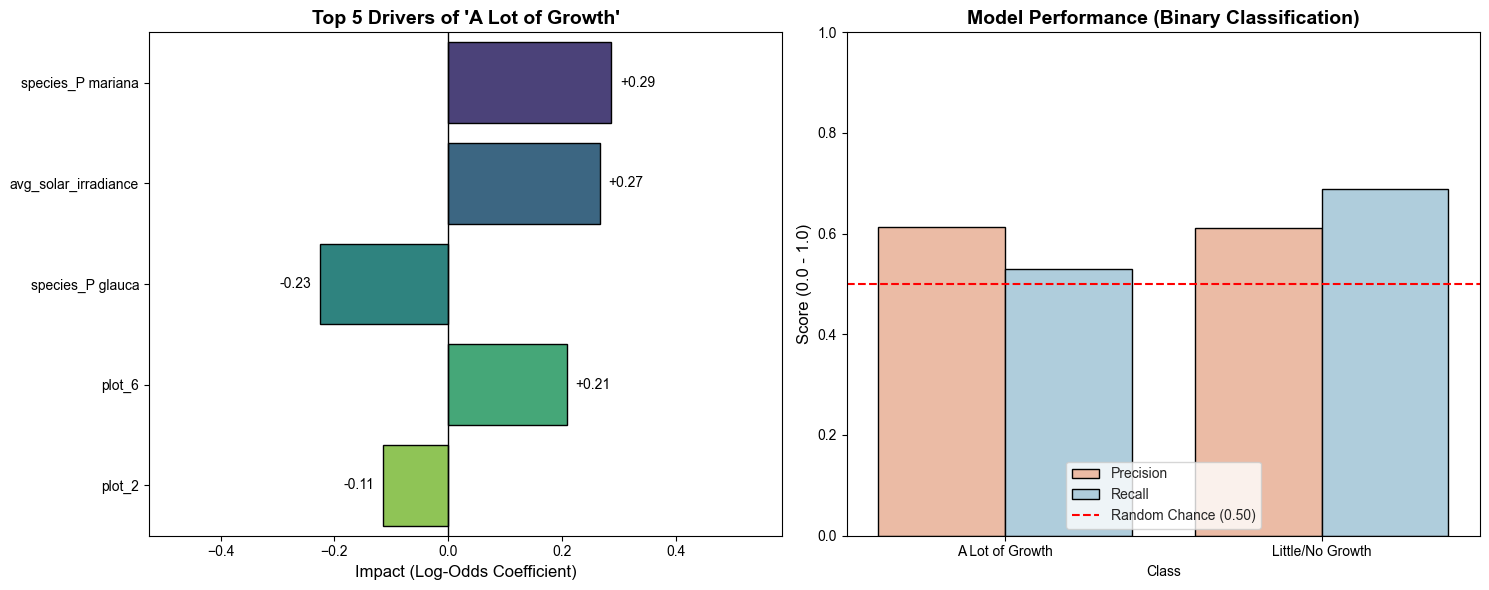

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.set_style("whitegrid")

# --- PLOT 1: Feature Importance ---
sns.barplot(
    x='Coefficient', 
    y='Feature', 
    hue='Feature',
    data=df_coef, 
    ax=axes[0], 
    palette='viridis', 
    edgecolor='black',
    legend=False
)
axes[0].set_title(f"Top 5 Drivers of '{target_class}'", fontsize=14, weight='bold')
axes[0].set_xlabel("Impact (Log-Odds Coefficient)", fontsize=12)
axes[0].set_ylabel("")
axes[0].axvline(0, color='black', linewidth=1)

# Dynamic X-Axis Limits
min_coef = df_coef['Coefficient'].min()
max_coef = df_coef['Coefficient'].max()
padding = max(0.3, (max_coef - min_coef) * 0.2)
axes[0].set_xlim(min_coef - padding, max_coef + padding)

for i, v in enumerate(df_coef['Coefficient']):
    offset = padding * 0.05
    axes[0].text(
        v + (offset if v > 0 else -offset), 
        i, 
        f"{v:+.2f}", 
        va='center', 
        ha='left' if v > 0 else 'right',
        fontsize=10, 
        color='black'
    )

# --- PLOT 2: Model Performance ---
sns.barplot(
    x='Class', 
    y='Score', 
    hue='Metric', 
    data=df_perf_melted, 
    ax=axes[1], 
    palette='RdBu', 
    edgecolor='black'
)
axes[1].set_title("Model Performance (Binary Classification)", fontsize=14, weight='bold')
axes[1].set_ylim(0, 1.0)
axes[1].set_ylabel("Score (0.0 - 1.0)", fontsize=12)
axes[1].axhline(0.5, color='red', linestyle='--', label='Random Chance (0.50)')
axes[1].legend(loc='lower center')

plt.tight_layout()
plt.show()
